In [1]:
from vqc_decoder_model_and_circuit import *

### Target Half Particle Distribution

In [2]:
# Target binary pattern
target_binary = "11110000"

target_binary1 = '1111'
target_binary2 = '0000'
# Convert binary to decimal index
target_index1 = int(target_binary1, 2)
target_index2 = int(target_binary2, 2)

# Create a one-hot encoded target distribution
num_qubits = 4
target_distribution1 = np.zeros(2**num_qubits)
target_distribution1[target_index1] = 1

target_distribution2 = np.zeros(2**num_qubits)
target_distribution2[target_index2] = 1

### Loss Function

In [3]:
from functools import partial

class MMD:
    def __init__(self,scales,space):
        gammas = 1/(2*(scales**2)).reshape(-1,1,1)
        sq_dists = jnp.abs(space[:,None] - space[None,:])**2
        self.K = jnp.sum(jnp.exp(-gammas * sq_dists), axis=0)/len(scales)
        self.scales = scales
        
    def k_expval(self,px,py):
        return px @ self.K @ py
    
    def __call__(self,px,py):
        pxy = px-py
        return self.k_expval(pxy,pxy)
    
class QCBM:
    def __init__(self,circ,mmd1,mmd2,py1,py2):
        self.circ = circ
        self.mmd1 = mmd1
        self.mmd2 = mmd2
        self.py1 = py1
        self.py2 = py2
    
    def mmd_loss(self,params):
        px = self.circ(params)
        loss1 = self.mmd1(px[0],self.py1)
        loss2 = self.mmd2(px[1],self.py2)
        
        return loss1+loss2, px
    

#Model Training
@partial(jax.jit, static_argnames=['qcbm'])
def update_step(params,opt_state,qcbm):
    
    (total_loss_val,qcbm_probs), grads = jax.value_and_grad(qcbm.mmd_loss,has_aux=True)(params)

    updates,opt_state = opt.update(grads,opt_state)
    params = optax.apply_updates(params,updates)
    
    qcbm_probs1 = jnp.asarray(qcbm_probs[0], dtype=jnp.float64)
    qcbm_probs2 = jnp.asarray(qcbm_probs[1], dtype=jnp.float64)
    
    kl_div1 = -jnp.sum(target_distribution1 * jnp.nan_to_num(jnp.log(qcbm_probs1) - jnp.log(target_distribution1)))
    kl_div2 = -jnp.sum(target_distribution2 * jnp.nan_to_num(jnp.log(qcbm_probs2) - jnp.log(target_distribution2)))
    
    total_kl_div = kl_div1 + kl_div2
    
    return params, opt_state, total_loss_val, total_kl_div

### Running the Model

In [4]:
#Calling MMD class
bandwidth = jnp.array([0.25,60],dtype=jnp.float64)
space = jnp.arange(0,2**n_qubits,dtype=jnp.float64)
mmd1 = MMD(bandwidth,space=space)
mmd2 = MMD(bandwidth,space=space)


# lr = optax.exponential_decay(init_value=0.1,transition_steps=10,decay_rate=0.99,transition_begin=300,end_value=0.01,staircase=True)
lr = 0.1
opt = optax.adam(learning_rate=lr)

#Function to get VQC generated cat
@qml.qnode(dev,interface='jax')
def output_vqc_circuit(input_params,vqc_folds,n_qubits=4):
    uniform_init(num_qubits,cat_pre_training,seed=0)
    params = input_params[0]
    for i in range(vqc_folds):
        vqc_circuit(params[i])
    return qml.probs(wires=range(n_qubits))



def run_model(folds_range):
    
    #Array to save all the anticat distributions
    generated_cat = []
    
    #fixed number of vqc folds
    qcbm_folds = folds_range[0]
    #For loop to run the model for different number of folds
    for folds in folds_range[1]:
        print("Running for folds: ",folds)

        vqc_folds = folds
        # Initialize a JAX random key
        key = jax.random.PRNGKey(0)
        key_vqc, key_qcbm = jax.random.split(key)  # Split the random key for different parts

        # Generate random parameters for VQC circuit
        vqc_params = jax.random.uniform(key_vqc, shape=(vqc_folds, 3 * n_qubits), minval=0.0, maxval=1.0)
        # Generate random parameters for QCBM circuit
        qcbm_params = jax.random.uniform(key_qcbm, shape=(qcbm_folds, 3 * total_qubits), minval=0.0, maxval=1.0)

        # Concatenate along the first axis (stacking the parameters)
        initial_params = (vqc_params, qcbm_params)
        
        ## Initializing the arrays to store the results
        history = []
        divs = []
        parameters = []
        kl_div = 1

        ## Initializing the model
        qcbm = QCBM(lambda params: circuit(params, vqc_folds=vqc_folds, qcbm_folds=qcbm_folds), mmd1=mmd1,mmd2=mmd2,py1=target_distribution1,py2=target_distribution2)
        weights = initial_params
        n_epochs = 1001
        opt_state = opt.init(weights)
        i = 0
        
        start_time = time.time()
        while i < n_epochs:
            i+=1
            current_lr = lr
            weights, opt_state, loss_val, kl_div = update_step(params=weights,opt_state=opt_state,qcbm=qcbm)
                  
            history.append(loss_val)
            divs.append(kl_div)
            parameters.append(weights)
        end_time = time.time()
        
        print(f"The minimum KL divergence obtained for {folds} folds : {min(divs)} in {n_epochs} epochs in {end_time-start_time} seconds")
        
        ## Obtaining the Anticat distribution
        optimal_params = parameters[np.argmin(divs)]
        qcbm_probs = output_vqc_circuit(optimal_params,vqc_folds,n_qubits)
        
        generated_cat.append(qcbm_probs)
    
    return generated_cat
                

In [6]:
folds_range = [3,[2,3,4,5,6,7,8,9]]
generated_cat = run_model(folds_range)

Running for folds:  2
The minimum KL divergence obtained for 2 folds : 0.0064800940454006195 in 1001 epochs in 37.97682309150696 seconds
Running for folds:  3
The minimum KL divergence obtained for 3 folds : 0.0012933025136590004 in 1001 epochs in 30.0086407661438 seconds
Running for folds:  4
The minimum KL divergence obtained for 4 folds : 0.0012352108024060726 in 1001 epochs in 36.08431649208069 seconds
Running for folds:  5
The minimum KL divergence obtained for 5 folds : 0.0010483628138899803 in 1001 epochs in 43.3287239074707 seconds
Running for folds:  6
The minimum KL divergence obtained for 6 folds : 0.0026054061017930508 in 1001 epochs in 53.52695393562317 seconds
Running for folds:  7
The minimum KL divergence obtained for 7 folds : 0.0029548765160143375 in 1001 epochs in 61.14235043525696 seconds
Running for folds:  8
The minimum KL divergence obtained for 8 folds : 0.0024838964454829693 in 1001 epochs in 67.22295784950256 seconds
Running for folds:  9
The minimum KL diverg

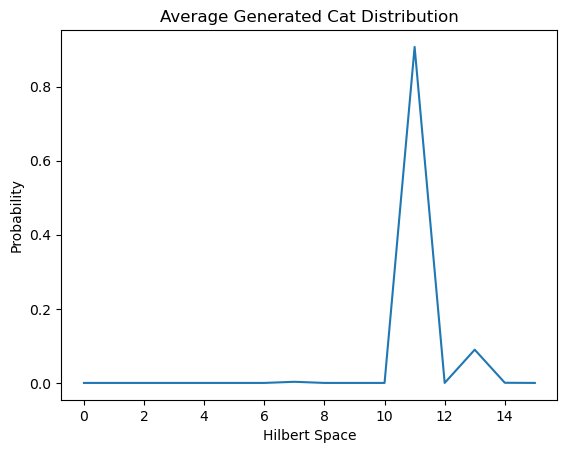

In [7]:
## Get the average anticat distribution from all anticat distributions from anticats array
generated_cats = np.array(generated_cat)
average_generated_cat = np.mean(generated_cats,axis=0)
x = np.arange(0,2**n_qubits)
plt.plot(x,average_generated_cat,label="Average Anticat")
plt.xlabel("Hilbert Space")
plt.ylabel("Probability")
plt.title("Average Generated Cat Distribution")
plt.show()


In [5]:
folds_range = [3,[2,3,4,5,6,7,8,9]]
generated_cat2 = run_model(folds_range)

Running for folds:  2
The minimum KL divergence obtained for 2 folds : 0.0014694961719214916 in 1001 epochs in 26.31384253501892 seconds
Running for folds:  3
The minimum KL divergence obtained for 3 folds : 0.001293540932238102 in 1001 epochs in 28.8745014667511 seconds
Running for folds:  4
The minimum KL divergence obtained for 4 folds : 0.001502243452705443 in 1001 epochs in 30.828258991241455 seconds
Running for folds:  5
The minimum KL divergence obtained for 5 folds : 0.0010409082751721144 in 1001 epochs in 34.38631200790405 seconds
Running for folds:  6
The minimum KL divergence obtained for 6 folds : 0.0017204530304297805 in 1001 epochs in 37.419790267944336 seconds
Running for folds:  7
The minimum KL divergence obtained for 7 folds : 0.0011533843353390694 in 1001 epochs in 41.33467507362366 seconds
Running for folds:  8
The minimum KL divergence obtained for 8 folds : 0.0012006189208477736 in 1001 epochs in 46.853476762771606 seconds
Running for folds:  9
The minimum KL dive

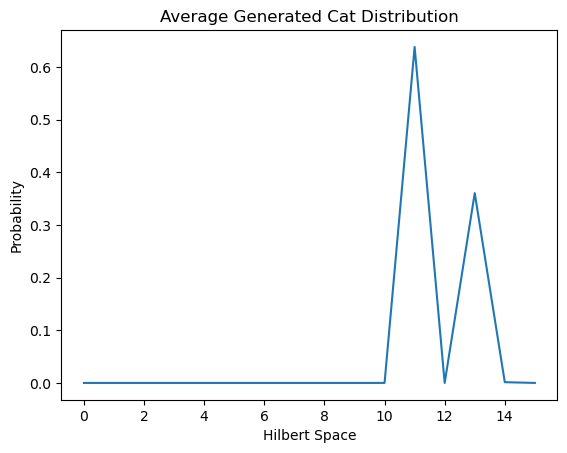

In [7]:
generated_cats2 = np.array(generated_cat2)
average_generated_cat2 = np.mean(generated_cats2,axis=0)
x = np.arange(0,2**n_qubits)
plt.plot(x,average_generated_cat2,label="Average Anticat")
plt.xlabel("Hilbert Space")
plt.ylabel("Probability")
plt.title("Average Generated Cat Distribution")
plt.show()